In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk(r"C:\Users\ohkba\OneDrive\Documents\Fake_news_detection"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\ohkba\OneDrive\Documents\Fake_news_detection\Fake.txt
C:\Users\ohkba\OneDrive\Documents\Fake_news_detection\True.txt


## Load and Check Data

In [6]:
real_data = pd.read_csv(r"C:\Users\ohkba\OneDrive\Documents\Fake_news_detection\True.txt")
fake_data = pd.read_csv(r"C:\Users\ohkba\OneDrive\Documents\Fake_news_detection\Fake.txt")

In [7]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [8]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
#add column 
real_data['target'] = 1
fake_data['target'] = 0 

In [10]:
real_data.tail()

,title,text,subject,date,target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [11]:
# Merging the real and fake datasets
raw_data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
raw_data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
raw_data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

no null values

In [13]:
raw_data.duplicated().sum()

209

In [14]:
# dropping 209 duplicates
data_no_dup = raw_data.drop_duplicates()

In [15]:
data_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44689 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44689 non-null  object
 1   text     44689 non-null  object
 2   subject  44689 non-null  object
 3   date     44689 non-null  object
 4   target   44689 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [16]:
data = data_no_dup
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [17]:
# resetting index as pandas tries to keep the index same after droping rows
data.reset_index(drop=True, inplace=True)
data.index

RangeIndex(start=0, stop=44689, step=1)

In [18]:
data.describe(include='all')

,title,text,subject,date,target
count,44689,44689,44689,44689,44689.000000
unique,38729,38646,8,2397,NaN
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 6, 2017",NaN
freq,14,627,11220,166,NaN
mean,NaN,NaN,NaN,NaN,0.474636
std,NaN,NaN,NaN,NaN,0.499362
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,1.000000


## Visualization

1.Count of Fake and Real Data

0    23478
1    21211
Name: target, dtype: int64


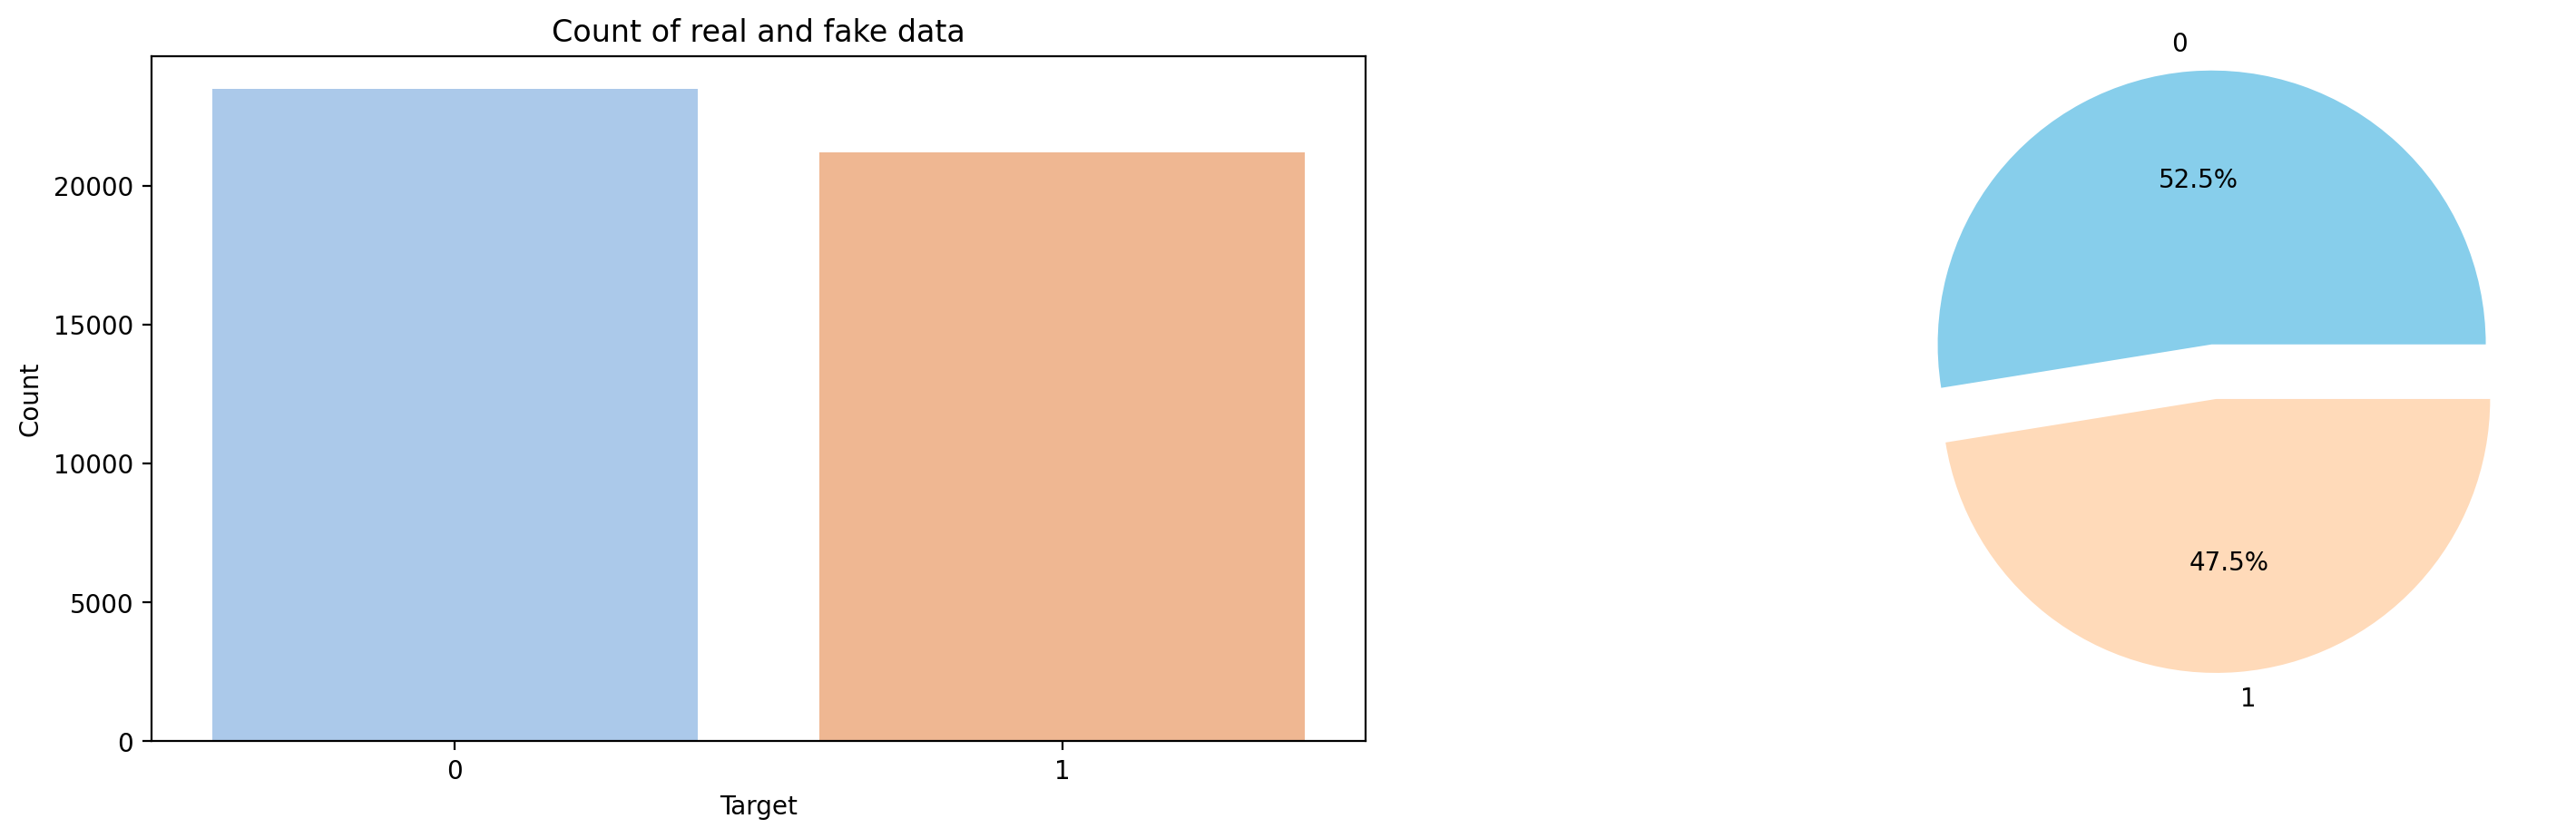

In [19]:
print(data["target"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5), dpi=200)
g1 = sns.countplot(data.target,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(data["target"].value_counts().values,explode=[0.2,0],labels=data.target.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

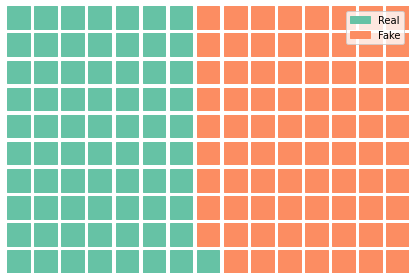

In [20]:
count=data['target'].value_counts()

from pywaffle import Waffle
fig = plt.figure(
        FigureClass = Waffle, 
        rows = 10, 
        columns= 15, 
        values= [count[1], count[0]], 
        labels = ['Real', 'Fake']
        )

2.Distribution of The Subject According to Real and Fake Data

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

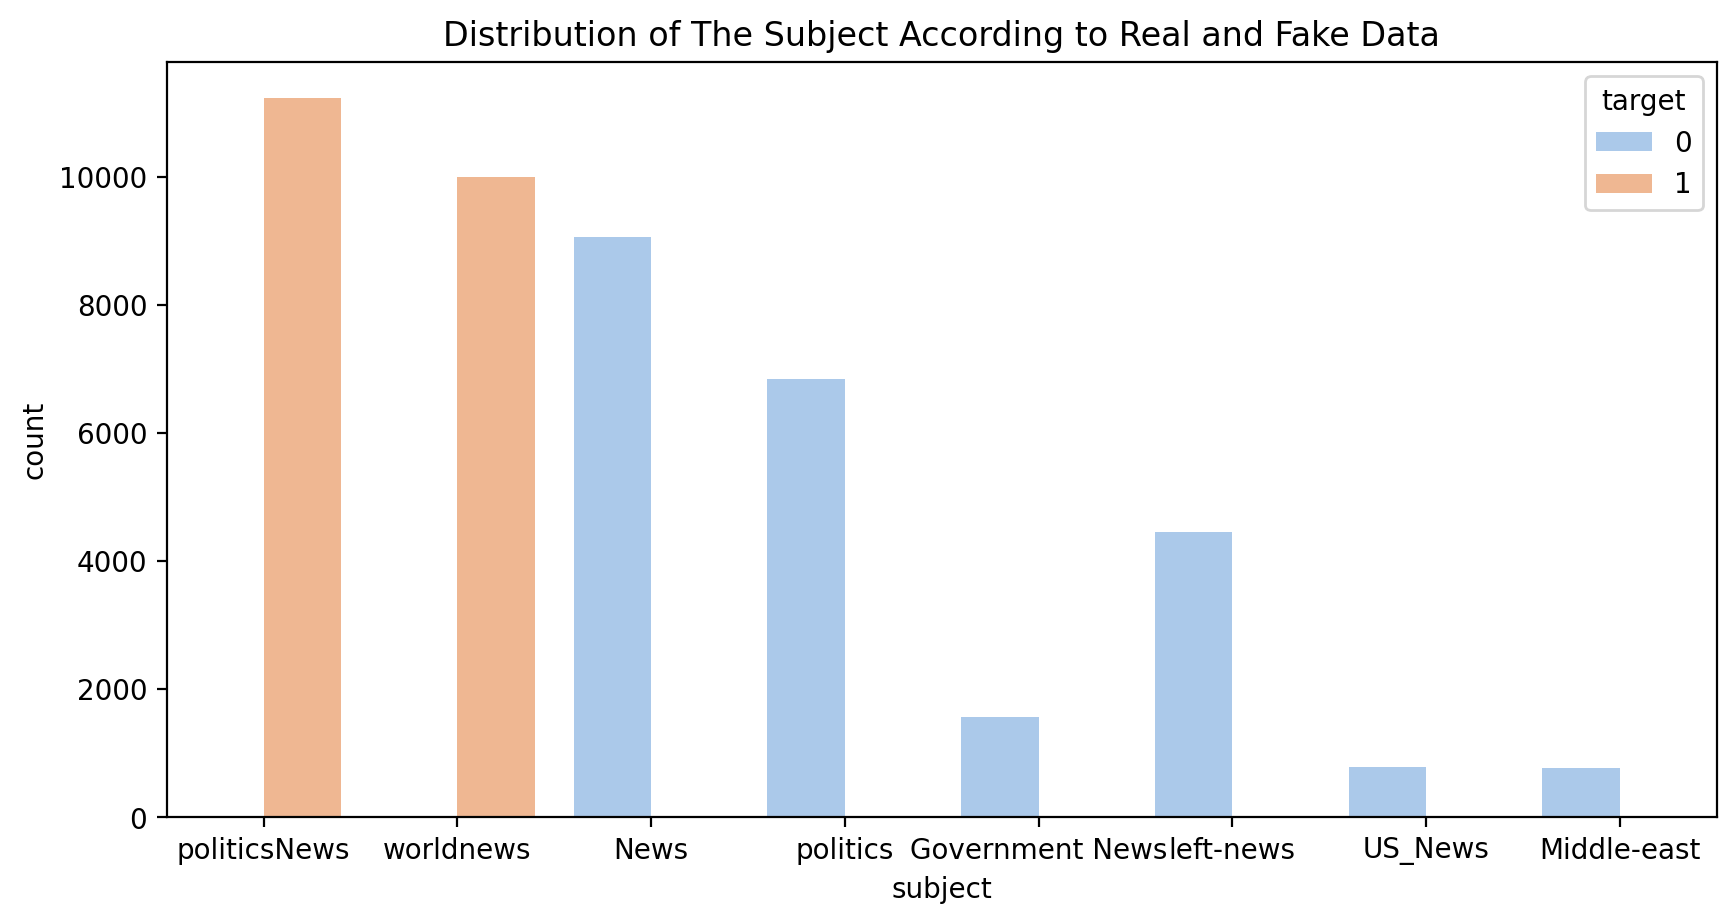

In [21]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5), dpi=200)

sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

## Data Cleaning

In [22]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
data.drop(columns=['title','subject','date'], inplace=True)
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44689 non-null  object
 1   target  44689 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 698.4+ KB


In [24]:
data.reset_index(drop=True, inplace=True)
data.index

RangeIndex(start=0, stop=44689, step=1)

In [25]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

## Removal of HTML Contents

In [26]:
# First, let's remove HTML content

In [27]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

## Removal of Punctuation Marks and Special Characters


In [28]:
first_text = re.sub(r'\[[^]]*\]', '', first_text)
first_text = re.sub(r'[^a-zA-Z0-9\s]', '', first_text)  # Remove all special characters (including punctuation)
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified us senate winner despite moore challenge reuters  alabama officials on thursday certified democrat doug jones the winner of the states us senate race after a state judge denied a challenge by republican roy moore whose campaign was derailed by accusations of sexual misconduct with teenage girls jones won the vacant seat by about 22000 votes or 16 percentage points election officials said that made him the first democrat in a quarter of a century to win a senate seat in alabama  the seat was previously held by republican jeff sessions who was tapped by us president donald trump as attorney general a state canvassing board composed of alabama secretary of state john merrill governor kay ivey and attorney general steve marshall certified the election results seating jones will narrow the republican majority in the senate to 51 of 100 seats in a statement jones called his victory a new chapter and pledged to work with both parties moore declined to concede def

## Removal of Stopwords

In [29]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ohkba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Convert the input message to lowercase
first_text = first_text.lower()

# Tokenize the lowercase message using NLTK
text_tokens = nltk.word_tokenize(first_text)

first_text = [ word for word in text_tokens if not word in set(stopwords.words("english"))]


In [31]:
#Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text] 

first_text = " ".join(first_text)
first_text

'politicsnews jones certified u senate winner despite moore challenge reuters alabama official thursday certified democrat doug jones winner state u senate race state judge denied challenge republican roy moore whose campaign derailed accusation sexual misconduct teenage girl jones vacant seat 22000 vote 16 percentage point election official said made first democrat quarter century win senate seat alabama seat previously held republican jeff session tapped u president donald trump attorney general state canvassing board composed alabama secretary state john merrill governor kay ivey attorney general steve marshall certified election result seating jones narrow republican majority senate 51 100 seat statement jones called victory new chapter pledged work party moore declined concede defeat even trump urged stood claim fraudulent election statement released certification said regret medium outlet reported alabama judge denied moore request block certification result dec 12 election decis

### Perform it for all the text in the data
We performed the steps for a single example. Now let's perform it for all the examples in the data.

In [32]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#Removal of Punctuation Marks, Special Characters
def clean_text(text):
    # Remove text in square brackets
    text = re.sub(r'\[[^]]*\]', '', text)
    
    # Remove all special characters (including punctuation)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    return cleaned_text

#Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)


#Total function
def cleaning(text):
    text = remove_html(text)
    text = clean_text(text)
    text = remove_stopwords_and_lemmatization(text)
    return text


In [33]:
#Apply function on text column

data['text']=data['text'].apply(cleaning)

In [34]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15), dpi=200)
wc = WordCloud(max_words = 500 , width = 1000 , height = 500, background_color='white', stopwords = STOPWORDS)

<Figure size 3000x3000 with 0 Axes>

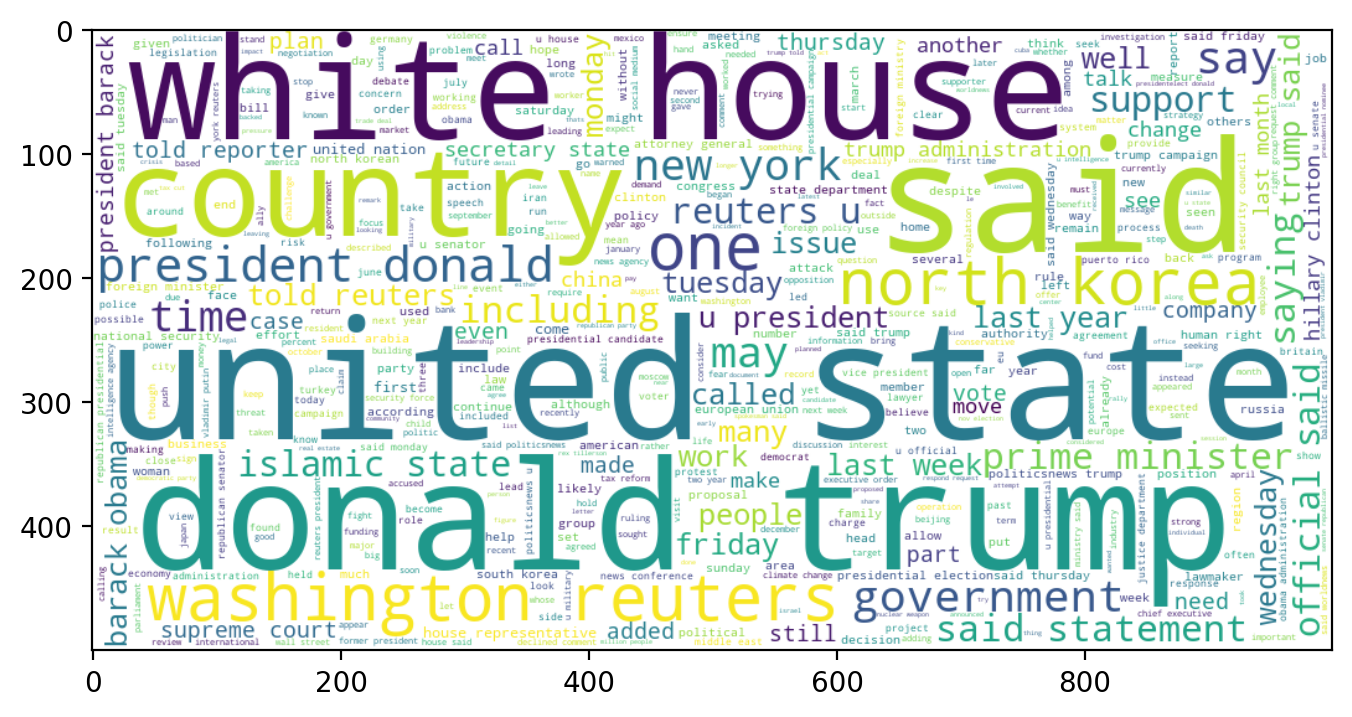

In [35]:
wc_real = wc.generate(" ".join(data[data.target == 1].text))
plt.figure(figsize=(8,12), dpi=200)
plt.imshow(wc, interpolation='bilinear')

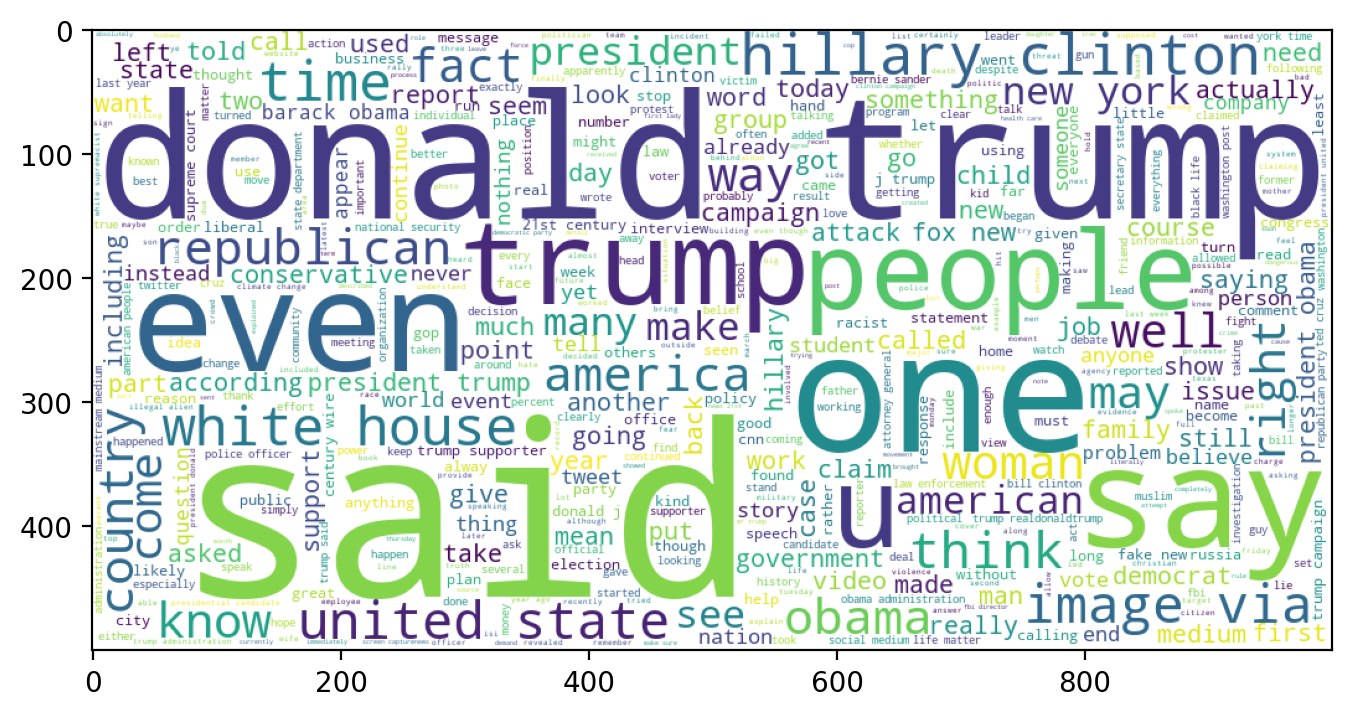

In [36]:
wc_fake = wc.generate(data[data['target']==0]['text'].str.cat(sep=""))
plt.figure(figsize=(8,12), dpi=200)
plt.imshow(wc)

### Number of Words in each text

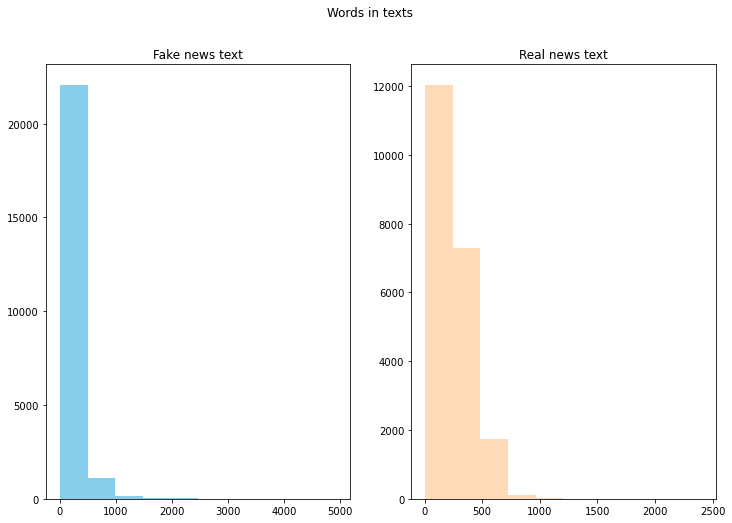

In [37]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

### N-Gram Analysis

In [38]:
texts = ' '.join(data['text'])
string = texts.split(" ")

In [39]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15] # nltk.ngrams to generate n grams
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16, 9), dpi=200)
    return sns.barplot(x='count',y='word', data=n_gram_df)

       word   count
0  (trump,)  141400
1   (said,)  129055
2      (u,)   67970
3  (state,)   59239
4  (would,)   55051


<AxesSubplot:xlabel='count', ylabel='word'>

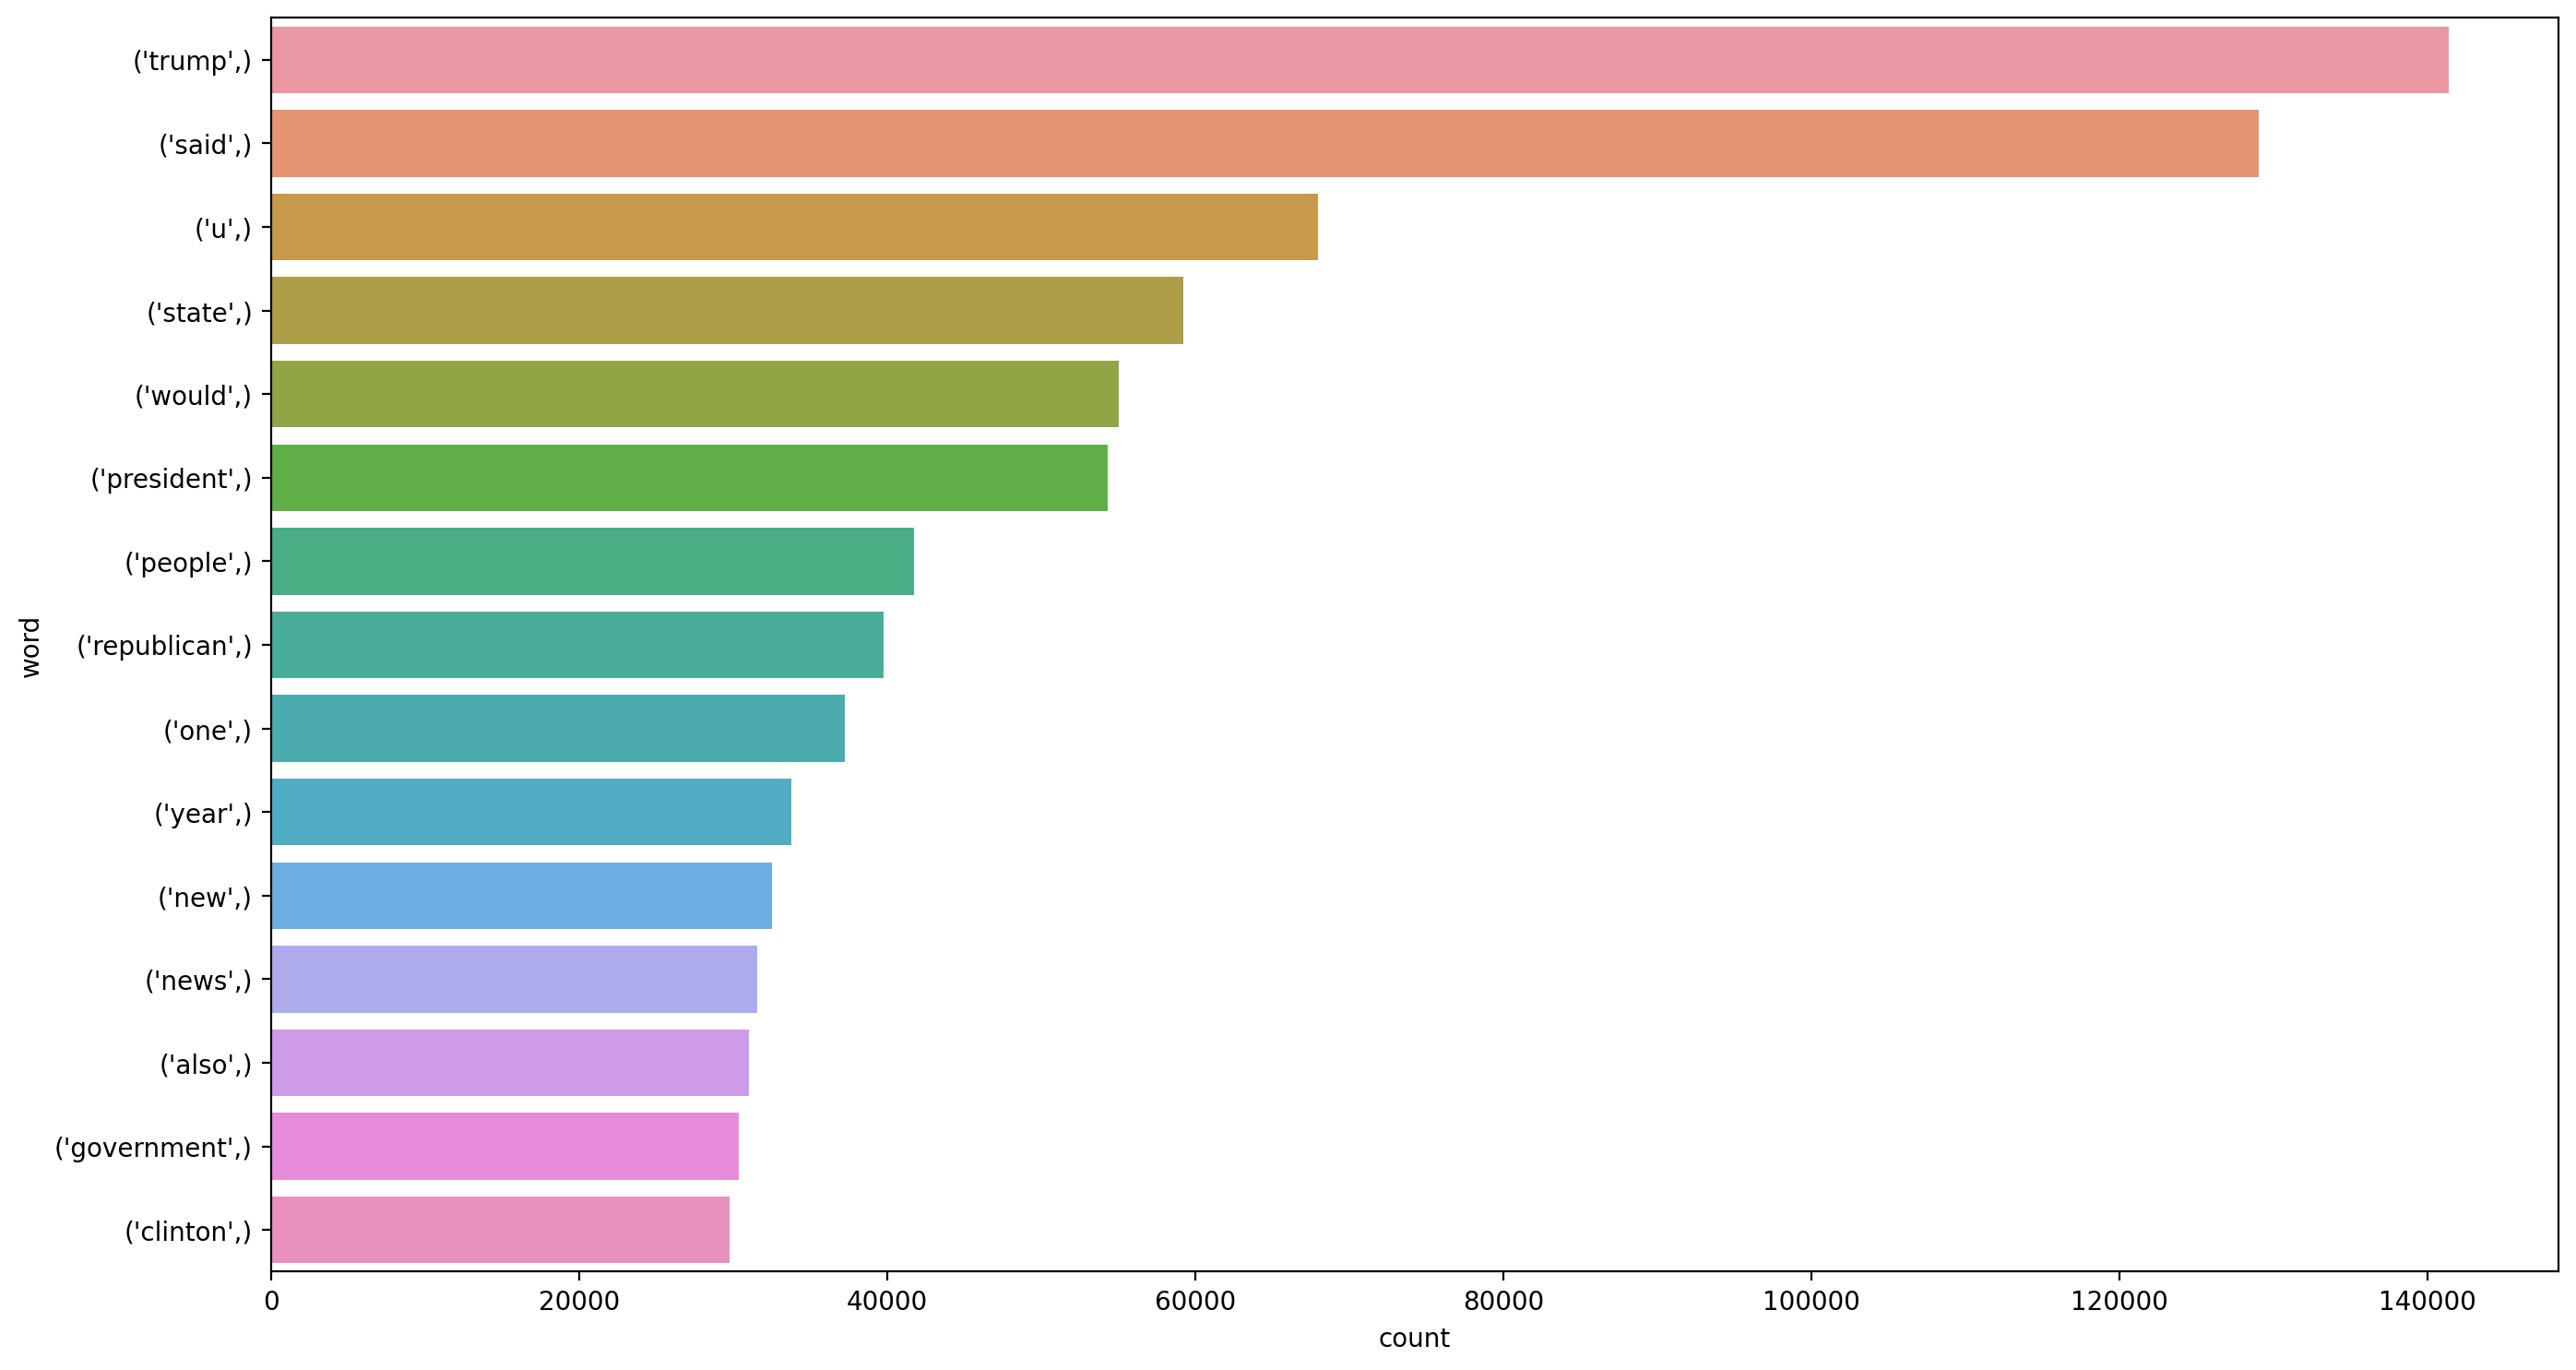

In [40]:
# Unigram Analysis
draw_n_gram(string,1)

                 word  count
0     (donald, trump)  23967
1     (united, state)  18246
2      (white, house)  15699
3  (hillary, clinton)   9605
4         (new, york)   8818


<AxesSubplot:xlabel='count', ylabel='word'>

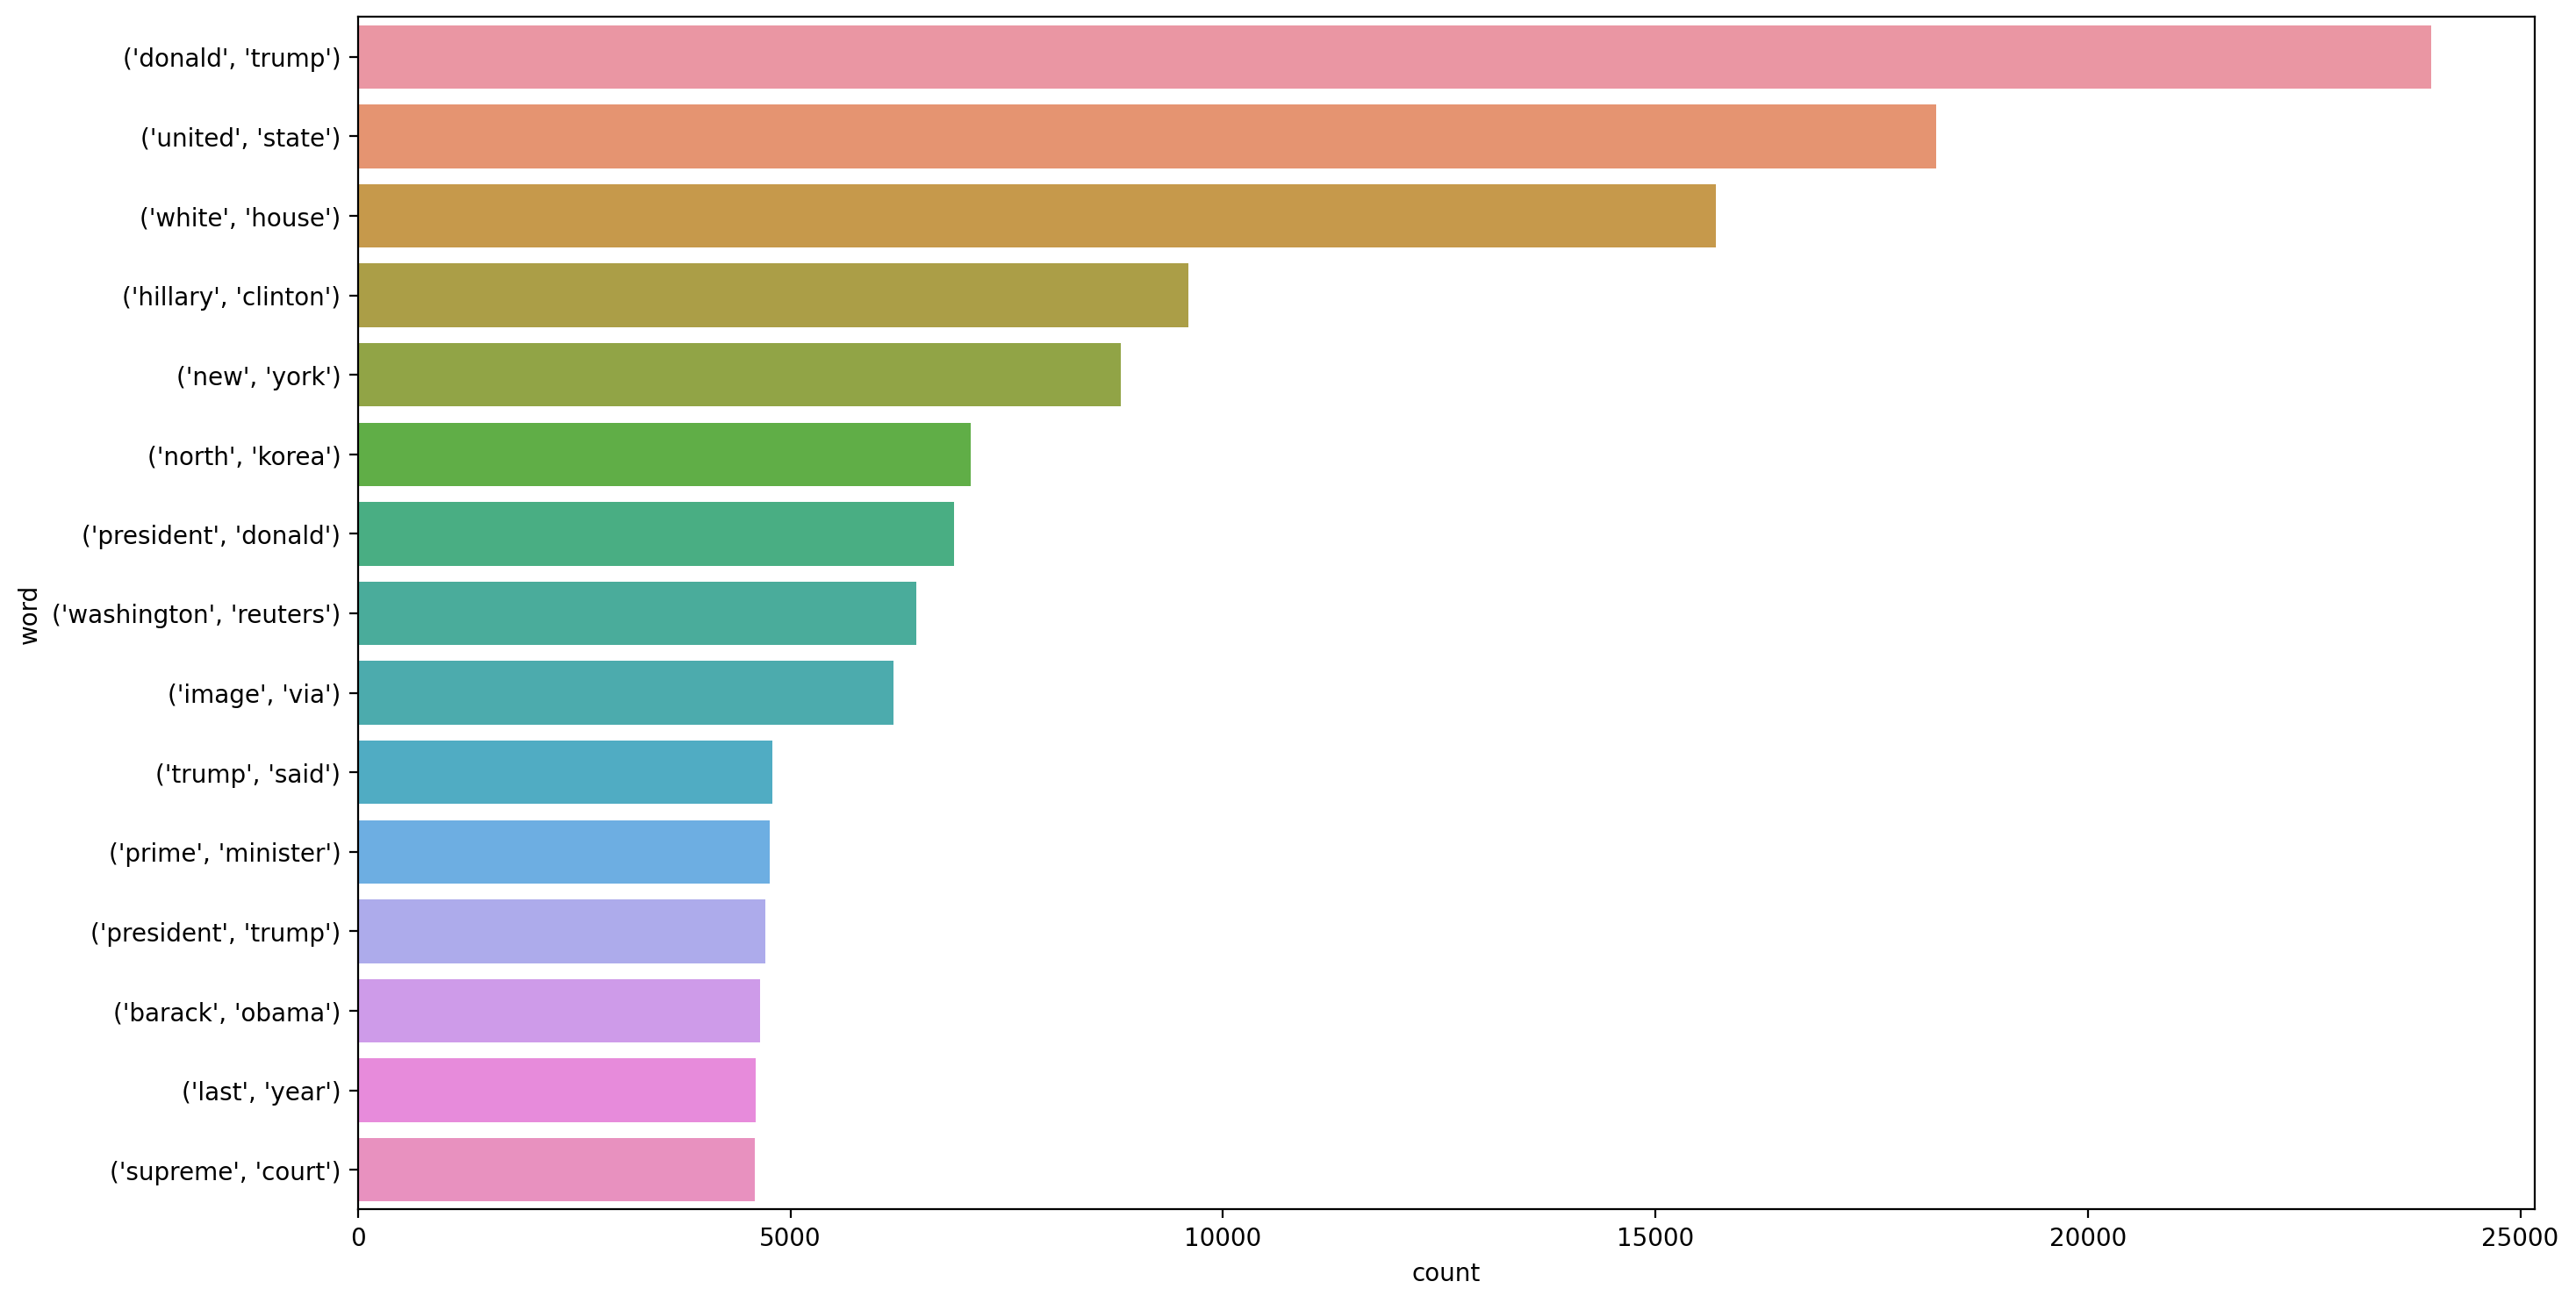

In [41]:
# Bigram Analysis
draw_n_gram(string,2)

                         word  count
0  (president, donald, trump)   6691
1  (president, barack, obama)   2845
2      (u, president, donald)   2555
3    (washington, reuters, u)   2341
4          (donald, j, trump)   2160


<AxesSubplot:xlabel='count', ylabel='word'>

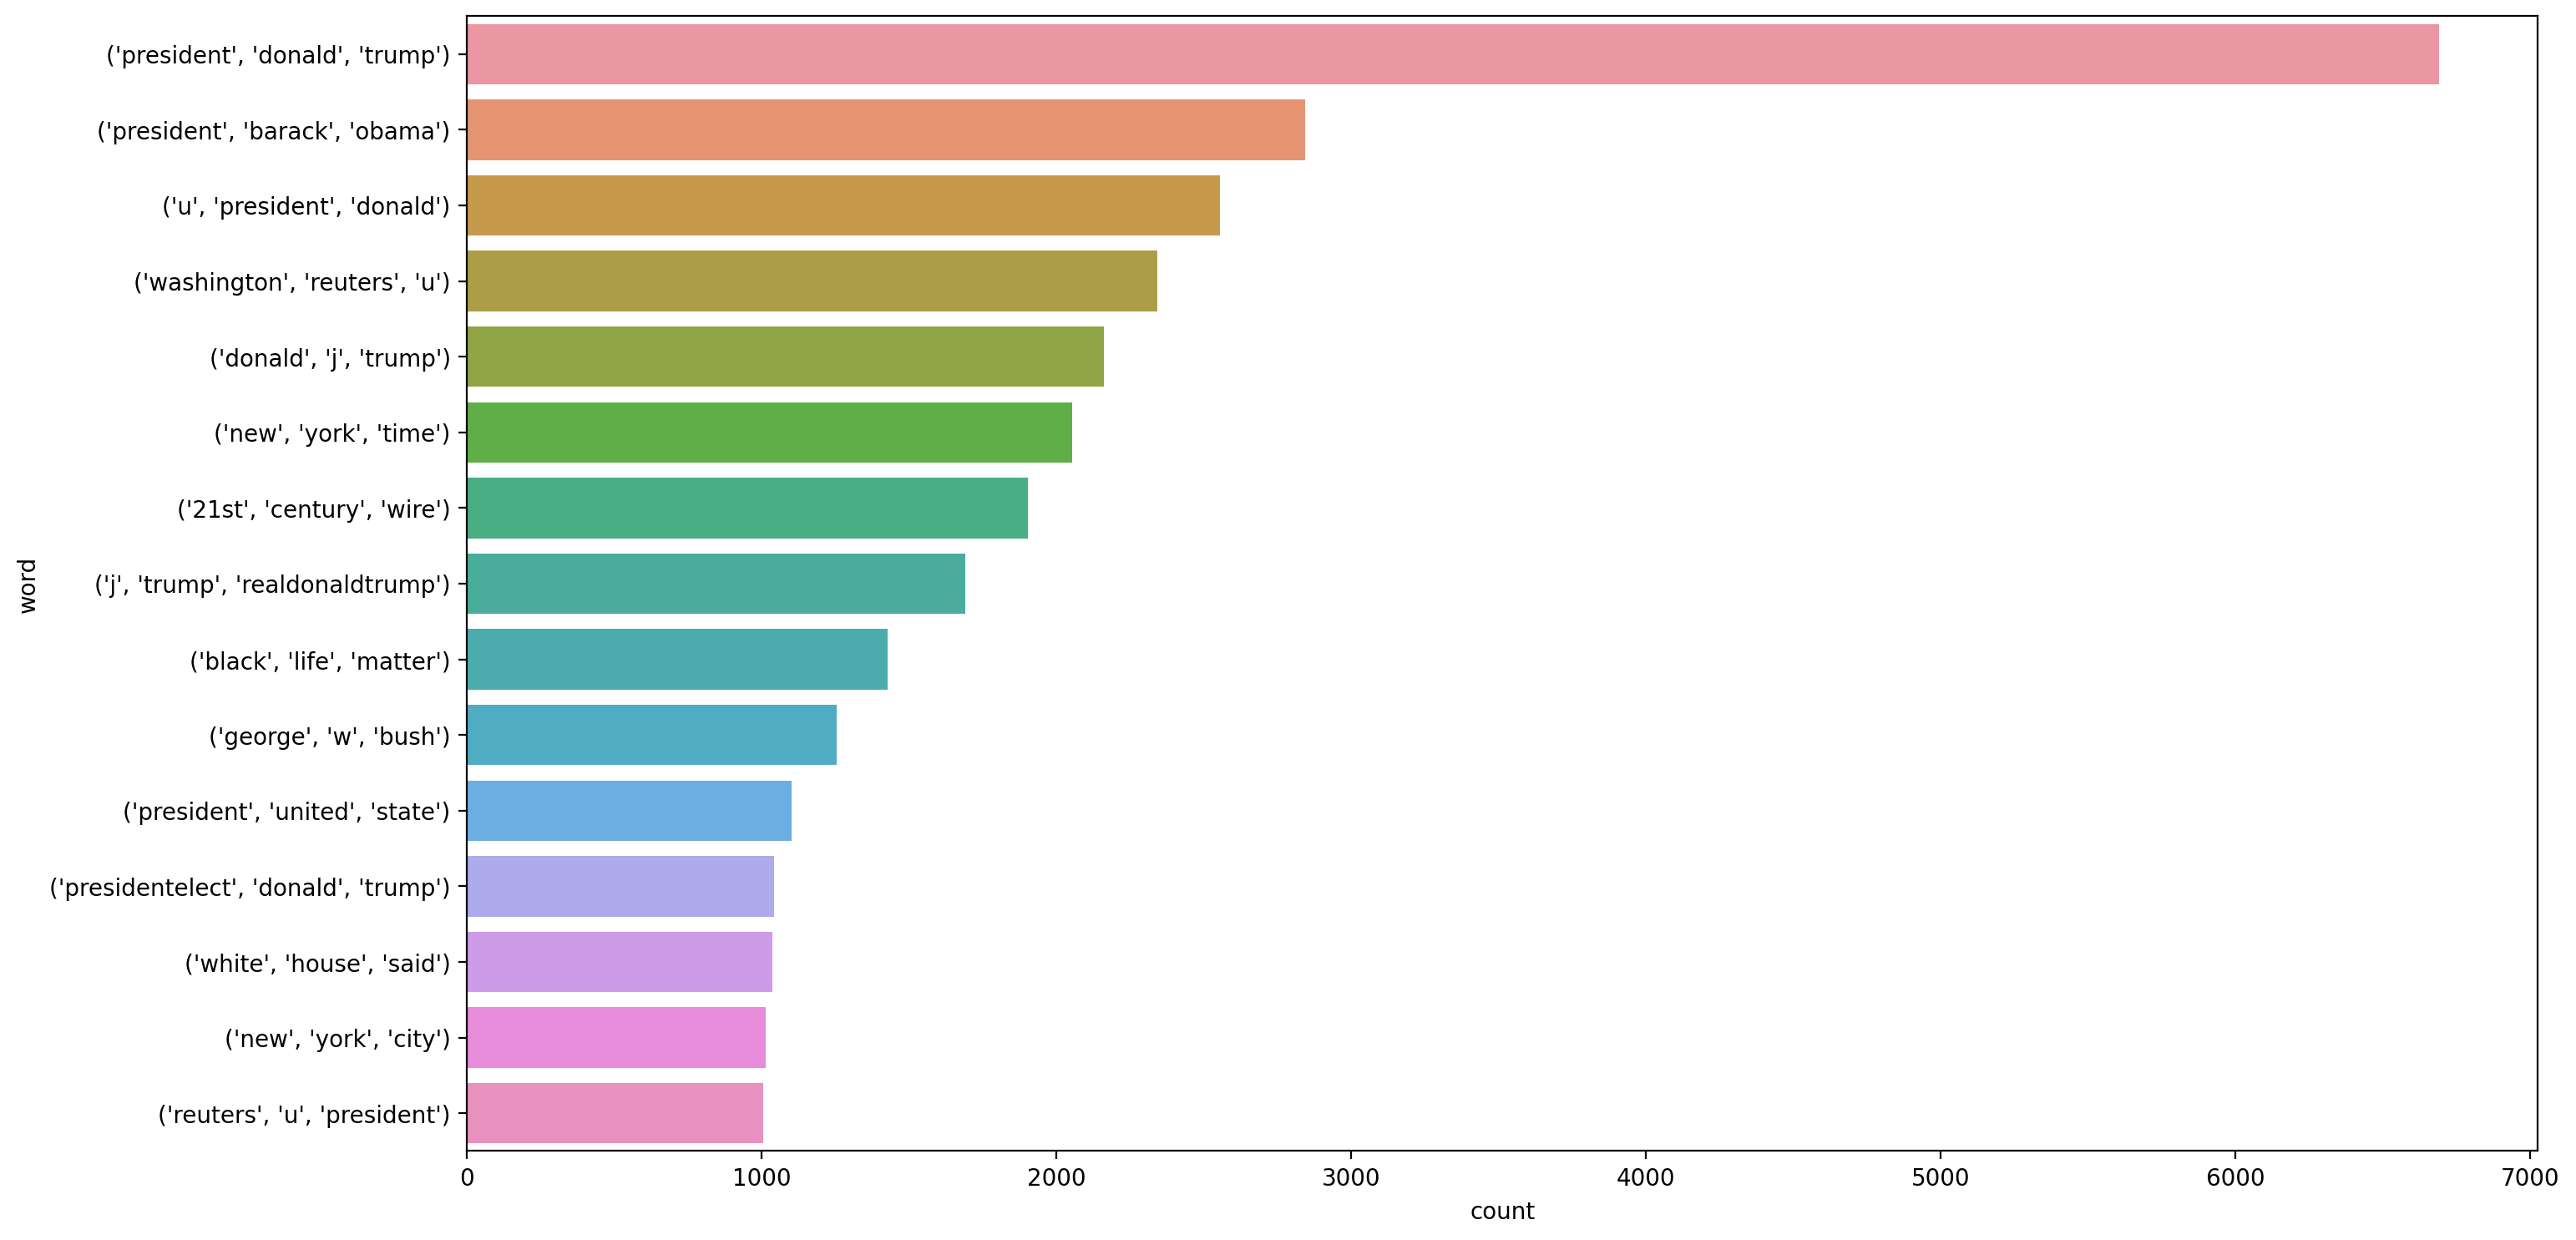

In [42]:
# Trigram Analysis
draw_n_gram(string,3)

## Modeling

In [43]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state= 365)

### Tokenizing
Tokenizing
Tokenizing Text -> Repsesenting each word by a number

Mapping of orginal word to number is preserved in word_index property of tokenizer

In [44]:
# Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones
max_features = 10000
maxlen = 300

In [45]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [46]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

### Training LSTM Model

In [47]:
batch_size = 256 # The number of samples processed before the model is updated
epochs = 10      # The number of complete passes through the training dataset
embed_size = 100 # The dimensionality of the embedding vectors. Each word will be represented as a vector of 100 dimensions.

In [48]:
model = Sequential()
# Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
# LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1168769 (4.46 MB)
Trainable params: 168769 (659.25 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [50]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
92/92 [==============================] - 1633s 18s/step - loss: 0.5186 - accuracy: 0.7155 - val_loss: 0.3510 - val_accuracy: 0.8389
Epoch 2/10
92/92 [==============================] - 2224s 24s/step - loss: 0.4797 - accuracy: 0.7518 - val_loss: 0.6898 - val_accuracy: 0.5103
Epoch 3/10
92/92 [==============================] - 1261s 14s/step - loss: 0.6129 - accuracy: 0.6384 - val_loss: 0.5272 - val_accuracy: 0.7258
Epoch 4/10
92/92 [==============================] - 1292s 14s/step - loss: 0.4361 - accuracy: 0.7820 - val_loss: 0.3404 - val_accuracy: 0.8498
Epoch 5/10
92/92 [==============================] - 1317s 14s/step - loss: 0.3558 - accuracy: 0.8330 - val_loss: 0.6200 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 1333s 14s/step - loss: 0.6400 - accuracy: 0.5831 - val_loss: 0.6216 - val_accuracy: 0.6984
Epoch 7/10
92/92 [==============================] - 1333s 14s/step - loss: 0.6215 - accuracy: 0.6201 - val_loss: 0.6279 - val_accuracy: 0.6050

### Analysis After Training

In [51]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1048/1048 [==============================] - 151s 144ms/step - loss: 0.5016 - accuracy: 0.7562
Accuracy of the model on Training Data is -  75.62358379364014 %
350/350 [==============================] - 48s 137ms/step - loss: 0.4990 - accuracy: 0.7554
Accuracy of the model on Testing Data is -  75.53924918174744 %


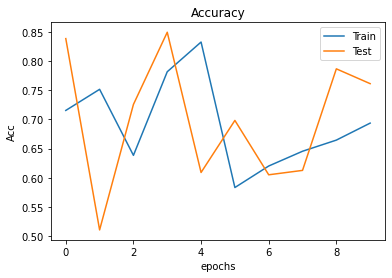

In [52]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

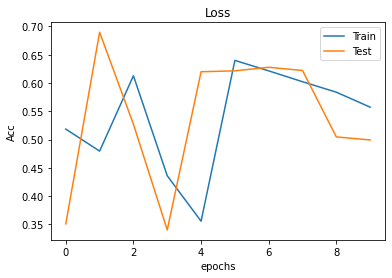

In [53]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [59]:
pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(y_test, pred, target_names = ['Fake','Real']))

350/350 [==============================] - 48s 138ms/step
              precision    recall  f1-score   support

        Fake       0.54      1.00      0.70      6000
        Real       0.00      0.00      0.00      5173

    accuracy                           0.54     11173
   macro avg       0.27      0.50      0.35     11173
weighted avg       0.29      0.54      0.38     11173

